# Simplification of encoding models based on tuning curves.



In [25]:
# Import useful modules
import os
import scipy
import random as rand
from scipy import io as sio
from scipy import stats
from scipy.stats.stats import pearsonr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd

import pickle
import itertools
import time

import copy

import multiprocessing as mp

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

import neural_proba
from neural_proba import distrib
from neural_proba import tuning_curve
from neural_proba import voxel
from neural_proba import experiment
from neural_proba import fmri

import utils

### To avoid scrolling windows

In [26]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Properties of the models

Here are the properties related to :
- the tuning curves (types, number, variance, ...) both true and fitted. 
- the neural mixture (sparsities)
- the subjects
- the sessions
- the SNR
- the type of linear regression performed

In [27]:
# All parameters are here

# Define the seed to reproduce results from random processes
rand.seed(4);

# INPUTS

# The parameters related to the scheme
scheme_array = ['gaussian_ppc', 'sigmoid_ppc', 'gaussian_dpc', 'sigmoid_dpc']
n_schemes = len(scheme_array)

# The parameters related to the tuning curves to be explored

N_array = np.array([2, 3, 4, 5, 6, 7, 8, 10, 14, 20])

t_mu_gaussian_array = np.array([0.15, 0.12, 0.1, 8e-2, 7e-2, 6e-2, 5e-2, 4e-2, 3e-2, 2e-2])
t_conf_gaussian_array = np.array([0.25, 0.2, 0.15, 0.12, 0.10, 9e-2, 8e-2, 6e-2, 4e-2, 3e-2])

# # Even N
#N_array = np.array([2, 4, 6, 8, 10, 14, 20])

#t_mu_gaussian_array = np.array([0.15, 0.1, 7e-2, 5e-2, 4e-2, 3e-2, 2e-2])
#t_conf_gaussian_array = np.array([0.25, 0.15, 0.10, 8e-2, 6e-2, 4e-2, 3e-2])


t_mu_sigmoid_array = np.sqrt(2*np.pi)/4*t_mu_gaussian_array
t_conf_sigmoid_array = np.sqrt(2*np.pi)/4*t_conf_gaussian_array

# Lower and upper bounds of the encoded summary quantity (for tuning curves) established from the histograms
tc_lower_bound_mu = 0
tc_upper_bound_mu = 1
tc_lower_bound_conf = 1.1
tc_upper_bound_conf = 2.6

# The number of N to be tested
n_N = len(N_array)

# The number of fractions tested (related to W): one per sparsity level combination
n_fractions = 20

# Sparsity exponents
sparsity_exp_array = np.array([1, 2, 4, 8])
n_sparsity_exp = len(sparsity_exp_array)

# The number of subjects
n_subjects = 1000

# The number of sessions
n_sessions = 4

# Experimental options
n_stimuli = 380    # The number of stimuli per session
between_stimuli_duration = 1.3
min_break_time = 8
max_break_time = 12
min_n_local_regular_stimuli = 12    # Min number of stimuli before a break
max_n_local_regular_stimuli = 18    # Max number of stimuli before a break


# Transition proba or Bernoulli proba
distrib_type = 'bernoulli'    #'bernoulli' or 'transition' 

# Load the corresponding data
[p1_dist_array, p1_mu_array, p1_sd_array] = neural_proba.import_distrib_param(n_subjects, n_sessions, n_stimuli,
                                                                                      distrib_type)

# SNR as defined by ||signal||²/(||signal||²+||noise||²). Mind the squares!
snr = 0.1

# fMRI info
final_frame_offset = 10  # Frame recording duration after the last stimulus has been shown
initial_frame_time = 0
dt = 0.125  # Temporal resolution of the fMRI scanner

between_scans_duration = 2  # in seconds
final_scan_offset = 10  # Scan recording duration after the last stimulus has been shown


# Type of regression
regr = linear_model.LinearRegression(fit_intercept=True, n_jobs=-1)
regr2 = linear_model.LinearRegression(fit_intercept=True, n_jobs=-1)

whitening_done = False


0.23156111335115953
0.2758692579931482


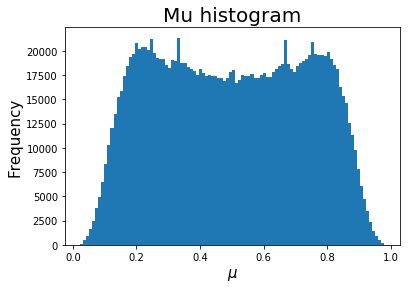

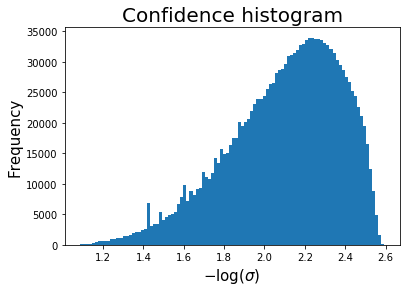

In [28]:
# Histograms of the distribution
all_mu = np.concatenate(p1_mu_array).ravel()    # All values of conf (for percentiles)

all_conf = -np.log(np.concatenate(p1_sd_array).ravel())    # All values of conf (for percentiles)

# THe quantity used for 
print(np.std(all_mu))
print(np.std(all_conf))
# To get the percentiles

fontsize=15
fig = plt.figure()
plt.hist(all_mu, bins=100)
plt.title("Mu histogram", fontsize=fontsize+5)
plt.xlabel("$\mu$", fontsize=fontsize)
plt.ylabel("Frequency", fontsize=fontsize)
plt.show()

fig = plt.figure()
plt.hist(all_conf, bins=100)
plt.title("Confidence histogram", fontsize=fontsize+5)
plt.xlabel("$-\log(\sigma)$", fontsize=fontsize)
plt.ylabel("Frequency", fontsize=fontsize)
plt.show()

mu_percentiles = np.percentile(all_mu, np.linspace(0, 100, 100))

conf_percentiles = np.percentile(all_conf, np.linspace(0, 100, 100))


## Handle the data

### Row data loading and visualization


In [29]:
# Load the design matrices and specify their size
#with open("output/design_matrices/X_par1.txt", "rb") as fp: #X_20sub_f.txt", "rb") as fp:   # Unpickling
#    X = pickle.load(fp)

In [30]:
# Just for now
n_subjects = 2
n_sessions = 4
n_N = len(N_array)
n_schemes = 4

In [31]:
# Create X
fmri_gain = 1    # Amplification of the signal

# Initialization of the design matrices and their zscore versions
X = [[[[None for k_session in range(n_sessions)] for k_subject in range(n_subjects)] for k_fit_N in range(n_N)]
     for k_fit_scheme in range(n_schemes)]

### WE BEGIN BY CREATING THE DESIGN MATRIX X
start = time.time()

for k_subject in range(n_subjects):
    ### Loop over the sessions : we start with it in order to have the same length whatever N_fit is
    for k_session in range(n_sessions):
        # Get the data of interest
        mu = p1_mu_array[k_subject, k_session, :n_stimuli]
        sigma = p1_sd_array[k_subject, k_session, :n_stimuli]
        conf = -np.log(sigma)
        dist = p1_dist_array[k_subject, k_session, :, :n_stimuli]

        # Formatting
        simulated_distrib = [None for k in range(n_stimuli)]
        for k in range(n_stimuli):
            # Normalization of the distribution
            norm_dist = dist[:, k] * (len(dist[1:, k]) - 1) / np.sum(dist[1:, k])
            simulated_distrib[k] = distrib(mu[k], sigma[k], norm_dist)

        # Experimental design information
        eps = 1e-5  # For floating points issues
        initial_time = between_stimuli_duration + eps
        final_time_tmp = between_stimuli_duration * (n_stimuli + 1) + eps
        # Every 15+-3 trials : one interruption of 8-12s
        stimulus_onsets = np.linspace(initial_time, final_time_tmp, n_stimuli)
        # We add some time to simulate breaks
        stimulus = 0

        while True:
            # Number of regularly spaced stimuli
            n_local_regular_stimuli = rand.randint(min_n_local_regular_stimuli, max_n_local_regular_stimuli)
            stimulus_shifted = stimulus + n_local_regular_stimuli  # Current stimulus before the break
            if stimulus_shifted > n_stimuli:  # The next break is supposed to occur after all stimuli are shown
                break
            stimulus_onsets[stimulus_shifted:] += rand.randint(min_break_time,
                                                               max_break_time) - between_stimuli_duration  # We consider a break of 8-12s
            stimulus = stimulus_shifted

        stimulus_durations = dt * np.ones_like(stimulus_onsets)  # Dirac-like stimuli

        # fMRI information
        final_time = stimulus_onsets[-1]
        final_frame_time = final_time + final_frame_offset

        initial_scan_time = initial_frame_time + between_scans_duration
        final_scan_time = final_time + final_scan_offset
        scan_times = np.arange(initial_scan_time, final_scan_time, between_scans_duration)

        # Creation of fmri object
        simu_fmri = fmri(initial_frame_time, final_frame_time, dt, scan_times)

        # Creation of experiment object
        exp = experiment(initial_time, final_time, n_sessions, stimulus_onsets, stimulus_durations, simulated_distrib)

        ### LOOP OVER THE SCHEME
        for k_fit_scheme in range(n_schemes):

            # Current schemes
            fit_scheme = scheme_array[k_fit_scheme]

            ### LOOP OVER THE FIT N's
            for k_fit_N in range(n_N):
                # Current N
                fit_N = N_array[k_fit_N]

                # Creation of the true tuning curve objects

                # We replace the right value of the "t"'s according to the type of tuning curve and the N
                if fit_scheme.find('gaussian') != -1:
                    fit_t_mu = t_mu_gaussian_array[k_fit_N]
                    fit_t_conf = t_conf_gaussian_array[k_fit_N]
                    fit_tc_type = 'gaussian'

                elif fit_scheme.find('sigmoid') != -1:
                    fit_t_mu = t_mu_sigmoid_array[k_fit_N]
                    fit_t_conf = t_conf_sigmoid_array[k_fit_N]
                    fit_tc_type = 'sigmoid'

                fit_tc_mu = tuning_curve(fit_tc_type, fit_N, fit_t_mu, tc_lower_bound_mu, tc_upper_bound_mu)
                fit_tc_conf = tuning_curve(fit_tc_type, fit_N, fit_t_conf, tc_lower_bound_conf,
                                             tc_upper_bound_conf)

                if fit_scheme.find('ppc') != -1:
                    fit_tc = [fit_tc_mu, fit_tc_conf]
                elif fit_scheme.find('dpc') != -1:
                    fit_tc = [fit_tc_mu]
                elif fit_scheme.find('rate') != -1:
                    fit_tc = []

                # Regressor and BOLD computation
                X[k_fit_scheme][k_fit_N][k_subject][k_session] = simu_fmri.get_regressor(exp, fit_scheme, fit_tc)
                # Just to have Xz with np array of the right structure
    end = time.time()
    print('Design matrix creation : Subject n'+str(k_subject)+' is done ! Time elapsed : '+str(end-start)+'s')

## Save this matrix
#with open("output/design_matrices/X.txt", "wb") as fp:   #Pickling
#    pickle.dump(X, fp)



Design matrix creation : Subject n0 is done ! Time elapsed : 2.9212374687194824s
Design matrix creation : Subject n1 is done ! Time elapsed : 5.81856369972229s


X of size : (365, 10)
Scheme : gaussian_ppc
N=5
Subject n°0
Session n°3

Tuning curve n°4 related to $\mu$
X of size : (365, 10)
Scheme : gaussian_ppc
N=5
Subject n°0
Session n°3

Tuning curve n°2 related to $-\log(\sigma)$


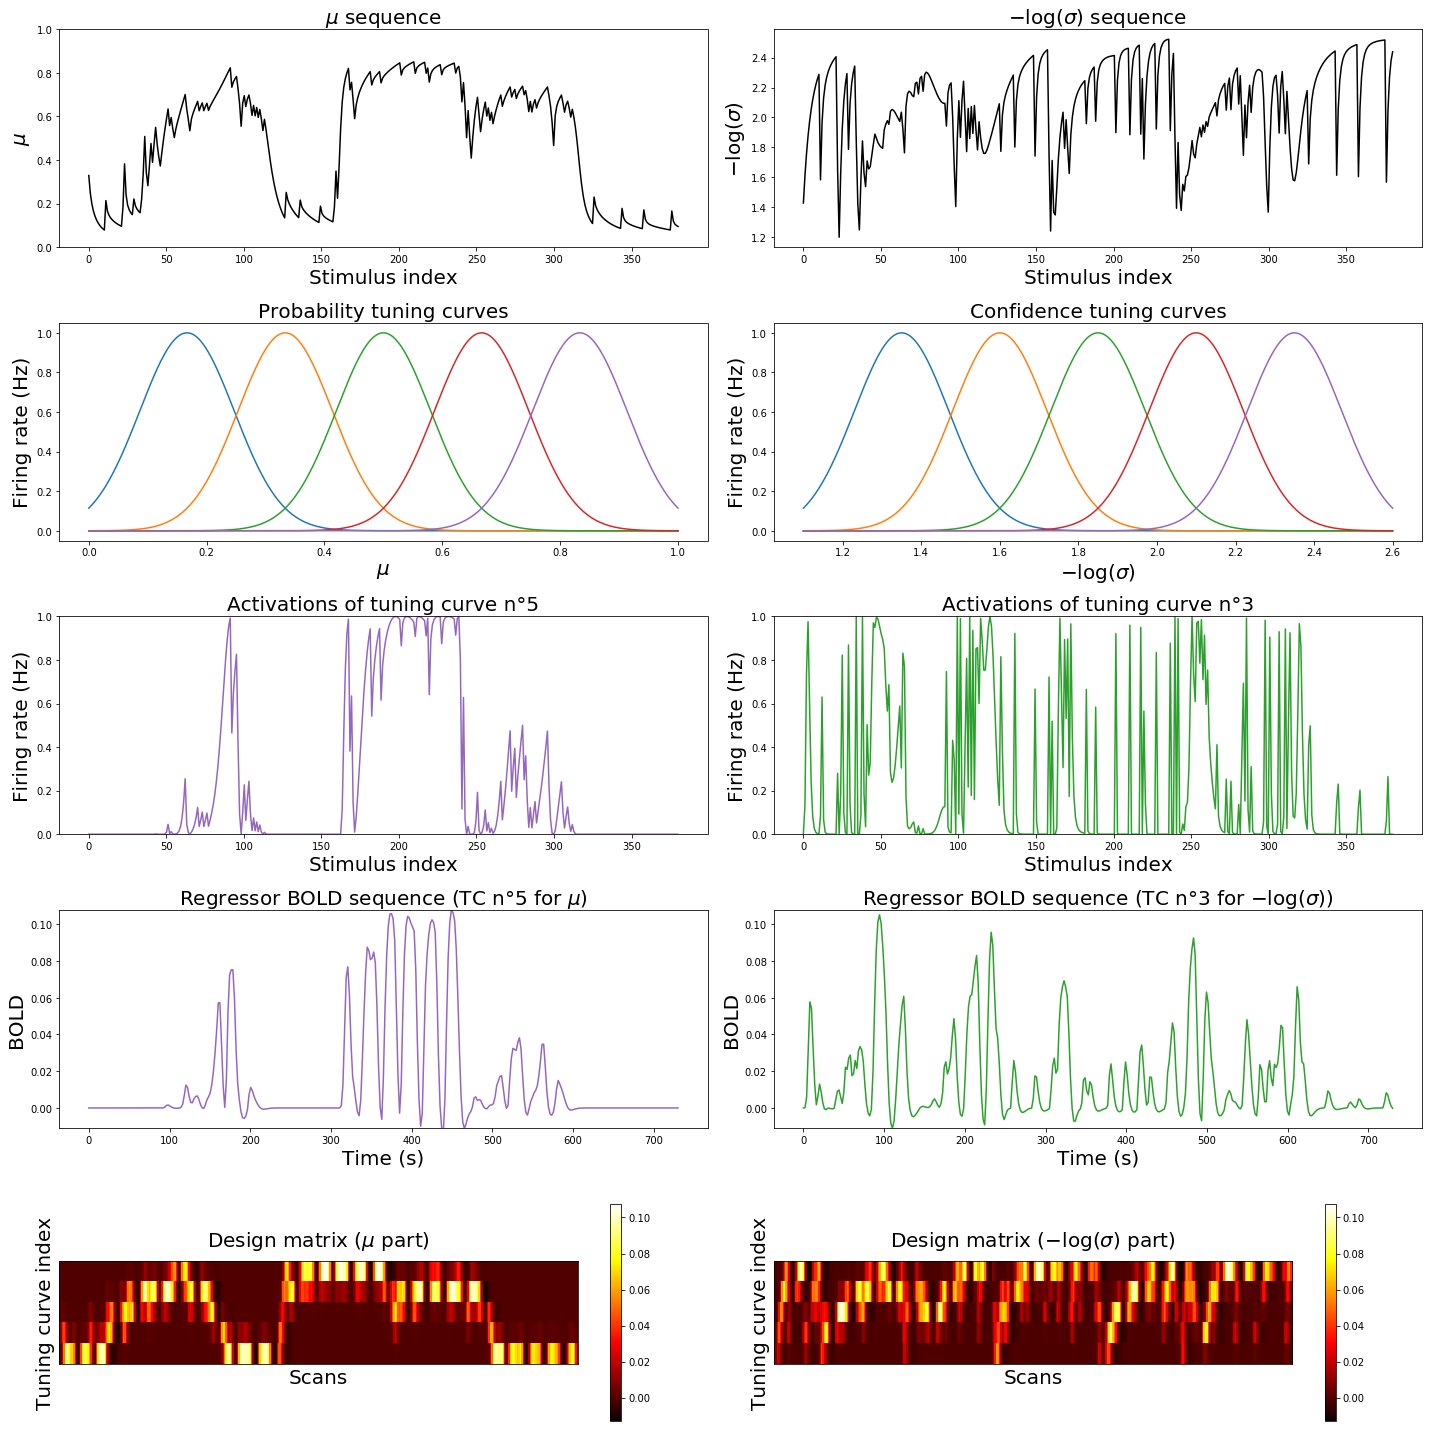

In [32]:
# Plot signal compared to summary statistics for the desired model
######################################################################################
k_scheme = 0
k_N = 3
k_fraction = 9
k_subject = 0
k_session = 3
#######################################################################################
# Tuning curve indices to visualize
i_mu = 4
i_conf = 2

# Test everything is fine
mu = p1_mu_array[k_subject, k_session, :n_stimuli]
sigma = p1_sd_array[k_subject, k_session, :n_stimuli]
conf = -np.log(sigma)
dist = p1_dist_array[k_subject, k_session, :, :n_stimuli]

scheme = scheme_array[k_scheme]
N = N_array[k_N]

# For gaussian PPC
if scheme.find('gaussian')!=-1:
    tc_type = 'gaussian'
    # For mu
    t_mu = t_mu_gaussian_array[k_N]
elif scheme.find('sigmoid')!=-1:
    tc_type = 'sigmoid'
    # For mu
    t_mu = t_mu_sigmoid_array[k_N]

tc_mu = tuning_curve(tc_type, N, t_mu, tc_lower_bound_mu, tc_upper_bound_mu)

tc_signal_mu =  tc_mu.f(mu, i_mu)

print('X of size : '+str(X[k_scheme][k_N][k_subject][k_session].shape))
data_signal_mu = copy.deepcopy(X[k_scheme][k_N][k_subject][k_session][:, i_mu])

n_scans = X[k_scheme][k_N][k_subject][k_session].shape[0]

# for color plots of all tuning curves
data_mu = np.zeros((N, n_scans))
for idx_mu in range(N):
    data_mu[idx_mu, :] = copy.deepcopy(X[k_scheme][k_N][k_subject][k_session][:, idx_mu])

bold_max = np.max(X[k_scheme][k_N][k_subject][k_session].flatten())

print('Scheme : '+scheme_array[k_scheme])
print('N='+str(N))
print('Subject n°'+str(k_subject))
print('Session n°'+str(k_session)+'\n')
print('Tuning curve n°'+str(i_mu)+' related to $\mu$')

# Only if we ask for PPC we display confidence plots
if scheme.find('ppc')!=-1:
    # For gaussian PPC
    if scheme.find('gaussian')!=-1:
        tc_type = 'gaussian'
        t_conf = t_conf_gaussian_array[k_N]
    elif scheme.find('sigmoid')!=-1:
        tc_type = 'sigmoid'
        t_conf = t_conf_sigmoid_array[k_N]
        
    tc_conf = tuning_curve(tc_type, N, t_conf, tc_lower_bound_conf, tc_upper_bound_conf)

    tc_signal_conf =  tc_conf.f(conf, i_conf)
    print('X of size : '+str(X[k_scheme][k_N][k_subject][k_session].shape))
    data_signal_conf = copy.deepcopy(X[k_scheme][k_N][k_subject][k_session][:, N+i_conf])
    data_conf = np.zeros((N, n_scans))
    for idx_conf in range(N):
        data_conf[idx_conf, :] = copy.deepcopy(X[k_scheme][k_N][k_subject][k_session][:, N+idx_conf])

    print('Scheme : '+scheme_array[k_scheme])
    print('N='+str(N))
    print('Subject n°'+str(k_subject))
    print('Session n°'+str(k_session)+'\n')
    print('Tuning curve n°'+str(i_conf)+' related to $-\log(\sigma)$')

fontsize = 20

### VISUALIZATION

fig = plt.figure(figsize=(20, 20))

# Mu sequence

ax1_up = fig.add_subplot(521)
ax1_up.plot(np.linspace(0, len(mu), len(mu)), mu, color='black')
ax1_up.set_xlabel('Stimulus index', fontsize=fontsize)
ax1_up.set_ylabel('$\mu$', fontsize=fontsize)
ax1_up.set_title('$\mu$ sequence', fontsize=fontsize)
ax1_up.set_ylim(0, 1)

# Tuning curves
ax1_down = fig.add_subplot(523)
mu = np.linspace(tc_lower_bound_mu, tc_upper_bound_mu, 1000)
tc_color = [None for k in range(N)]
for k in range(N):
    p = ax1_down.plot(mu, tc_mu.f(mu, k))
    tc_color[k] = p[0].get_color()
ax1_down.set_xlabel('$\mu$', fontsize=fontsize)
ax1_down.set_ylabel('Firing rate (Hz)', fontsize=fontsize)
ax1_down.set_title('Probability tuning curves', fontsize=fontsize)

# Tuning curve value sequence
ax_up = fig.add_subplot(525)
ax_up.plot(np.linspace(0, n_stimuli, n_stimuli), tc_signal_mu, color=tc_color[i_mu])
ax_up.set_xlabel('Stimulus index', fontsize=fontsize)
ax_up.set_ylim(0, 1)
ax_up.set_ylabel('Firing rate (Hz)', fontsize=fontsize)
ax_up.set_title('Activations of tuning curve n°'+str(i_mu+1), fontsize=fontsize)

ax_down = fig.add_subplot(527)
between_scans_time = 2.0
ax_down.set_xlabel('Time (s)', fontsize=fontsize)
ax_down.set_ylabel('BOLD', fontsize=fontsize)
ax_down.set_title('Regressor BOLD sequence (TC n°'+str(i_mu+1)+' for $\mu$)', fontsize=fontsize)
ax_down.set_ylim(-bold_max/10, bold_max)
ax_down.plot(np.linspace(0, between_scans_time*len(data_signal_mu), len(data_signal_mu)), data_signal_mu, color=tc_color[i_mu])

ax = fig.add_subplot(529)
heatmap = plt.imshow(data_mu, extent=[0, 5, 0, 1], cmap="hot")
# put the major ticks at the middle of each cell
ax.set_xticks([])
ax.set_yticks([])
ax.invert_yaxis()

# # want a more natural, table-like display
ax.xaxis.tick_top()
ax.set_ylabel('Tuning curve index', fontsize=fontsize)
ax.set_xlabel('Scans', fontsize=fontsize)
ax.set_title('Design matrix ($\mu$ part)', y=1.08, fontsize=fontsize)
plt.colorbar()

# Only if we ask for PPC we display confidence plots
if scheme.find('ppc')!=-1:
    # Confidence sequence
    conf = -np.log(p1_sd_array[k_subject, k_session, :n_stimuli])
    ax1__up = fig.add_subplot(522)
    ax1__up.plot(np.linspace(0, len(conf), len(conf)), conf, color='black')
    ax1__up.set_xlabel('Stimulus index', fontsize=fontsize)
    ax1__up.set_ylabel('$-\log(\sigma)$', fontsize=fontsize)
    ax1__up.set_title('$-\log(\sigma)$ sequence', fontsize=fontsize)

    # Tuning curves
    ax1__down = fig.add_subplot(524)
    conf = np.linspace(tc_lower_bound_conf, tc_upper_bound_conf, 1000)
    tc_color = [None for k in range(N)]
    for k in range(N):
        p = ax1__down.plot(conf, tc_conf.f(conf, k))
        tc_color[k] = p[0].get_color()
    ax1__down.set_xlabel('$-\log(\sigma)$', fontsize=fontsize)
    ax1__down.set_ylabel('Firing rate (Hz)', fontsize=fontsize)
    ax1__down.set_title('Confidence tuning curves', fontsize=fontsize)

    # Tuning curve value sequence
    ax__up = fig.add_subplot(526)
    ax__up.plot(np.linspace(0, n_stimuli, n_stimuli), tc_signal_conf, color=tc_color[i_conf])
    ax__up.set_xlabel('Stimulus index', fontsize=fontsize)
    ax__up.set_ylim(0, 1)
    ax__up.set_ylabel('Firing rate (Hz)', fontsize=fontsize)
    ax__up.set_title('Activations of tuning curve n°'+str(i_conf+1), fontsize=fontsize)

    ax__down = fig.add_subplot(528)
    between_scans_time = 2.0
    ax__down.set_xlabel('Time (s)', fontsize=fontsize)
    ax__down.set_ylabel('BOLD', fontsize=fontsize)
    ax__down.set_title('Regressor BOLD sequence (TC n°'+str(i_conf+1)+' for $-\log(\sigma)$)', fontsize=fontsize)
    ax__down.set_ylim(-bold_max/10, bold_max)
    ax__down.plot(np.linspace(0, between_scans_time*len(data_signal_conf), len(data_signal_conf)), data_signal_conf, color=tc_color[i_conf])
    
    ax = fig.add_subplot(5,2,10)
    heatmap = ax.imshow(data_conf, extent=[0, 5, 0, 1], cmap="hot")
    # put the major ticks at the middle of each cell
    ax.set_xticks([])
    ax.set_yticks([])
    ax.invert_yaxis()

    # # want a more natural, table-like display
    ax.xaxis.tick_top()
    ax.set_ylabel('Tuning curve index', fontsize=fontsize)
    ax.set_xlabel('Scans', fontsize=fontsize)
    ax.set_title('Design matrix ($-\log(\sigma)$ part)', y=1.08, fontsize=fontsize)
    plt.colorbar()

fig.tight_layout() 
plt.show()
#fig.savefig("figures_tmp/regressor_sequence.pdf", bbox_inches='tight')



# Future whitening visualization (with mu)
X_before_whitening = copy.deepcopy(X)

### Whiten the design matrix

In [33]:
# Whiten the design matrices

# Whitening matrix
white_mat = sio.loadmat('data/simu/whitening_matrix.mat')
W = white_mat['W']
# Complete the in-between session "holes"
W[300:600, 300:600] = W[20:320, 20:320]

if not whitening_done:
    # Multiplying the zscored X with the whitening matrix
    for k_scheme, k_fit_N, k_subject, k_session in itertools.product(range(n_schemes), range(n_N), range(n_subjects), range(n_sessions)):
        X_tmp = copy.deepcopy(X[k_scheme][k_fit_N][k_subject][k_session])    # Just to lighten code
        rows_dim, columns_dim = X_tmp.shape
        X_tmp = np.matmul(W[:rows_dim, :rows_dim], X_tmp)
        X[k_scheme][k_fit_N][k_subject][k_session] = copy.deepcopy(X_tmp)

whitening_done = True

X_after_whitening = copy.deepcopy(X)

### Computes the response vectors


In [34]:
# Creation of y from X to save computational resources
# Initialization of the response vectors
y = [[[[[None for k_session in range(n_sessions)] for k_subject in range(n_subjects)] for k_fraction in range(n_fractions)]
for k_true_N in range(n_N)] for k_scheme in range(n_schemes)]

# Initialization of the weights
weights = [[[[None for k_subject in range(n_subjects)] for k_fraction in range(n_fractions)] for k_true_N in range(n_N)]
           for k_scheme in range(n_schemes)]


### LOOP OVER THE SCHEME
for k_scheme in range(n_schemes):
    true_scheme = scheme_array[k_scheme]

    # We replace the right value of the "t"'s according to the type of tuning curve

    if true_scheme.find('gaussian') != -1:
        true_t_mu_array = copy.deepcopy(t_mu_gaussian_array)
        true_t_conf_array = copy.deepcopy(t_conf_gaussian_array)
        true_tc_type = 'gaussian'

    elif true_scheme.find('sigmoid') != -1:
        true_t_mu_array = copy.deepcopy(t_mu_sigmoid_array)
        true_t_conf_array = copy.deepcopy(t_conf_sigmoid_array)
        true_tc_type = 'sigmoid'

    # We consider combinations of population fractions for PPC and rate codes
    if true_scheme.find('ppc') != -1 or true_scheme.find('rate') != -1:
        # The number of population fraction tested (related to W)
        population_fraction_array = copy.deepcopy(np.array([[0.5, 0.5], [0.25, 0.75], [0, 1], [0.75, 0.25], [1, 0]]))
    elif true_scheme.find('dpc') != -1:  # DPC case
        population_fraction_array = copy.deepcopy(np.array([[1]]))
    n_population_fractions = len(population_fraction_array)

    ### LOOP OVER N_true
    for k_true_N in range(n_N):
        true_N = N_array[k_true_N]
        # Creation of the true tuning curve objects
        true_t_mu = true_t_mu_array[k_true_N]
        true_t_conf = true_t_conf_array[k_true_N]
        true_tc_mu = tuning_curve(true_tc_type, true_N, true_t_mu, tc_lower_bound_mu, tc_upper_bound_mu)
        true_tc_conf = tuning_curve(true_tc_type, true_N, true_t_conf, tc_lower_bound_conf,
                                     tc_upper_bound_conf)

        if true_scheme.find('ppc') != -1:
            true_tc = [true_tc_mu, true_tc_conf]
        elif true_scheme.find('dpc') != -1:
            true_tc = [true_tc_mu]
        elif true_scheme.find('rate') != -1:
            true_tc = []

        ### LOOP OVER THE SUBJECTS
        for k_subject in range(n_subjects):

            ### LOOP OVER THE W's
            # The number of subpopulation fractions acc. to the scheme
            n_subpopulation_fractions = int(n_fractions / n_population_fractions)
            fraction_counter = 0
            for k_subpopulation_fraction in range(n_subpopulation_fractions):
                for k_population_fraction, population_fraction in enumerate(population_fraction_array):
                    # The number of populations acc. to the scheme (2 for PPC and rate, 1 for DPC)
                    n_population = len(population_fraction)
                    if true_scheme.find('ppc') != -1 or true_scheme.find('dpc') != -1:
                        # We consider one sparsity per remainder value of the counter divided by the number
                        # of combinations to be tested
                        subpopulation_sparsity_exp = sparsity_exp_array[fraction_counter % n_sparsity_exp]
                        # Fraction of each neural subpopulation
                        subpopulation_fraction = neural_proba.get_subpopulation_fraction(n_population, true_N,
                                                                                         subpopulation_sparsity_exp)
                    # Generate the data from the voxel
                    true_voxel = voxel(true_scheme, population_fraction, subpopulation_fraction, true_tc)
                    n_true_features = n_population * true_N
                    weights_tmp = copy.deepcopy(np.reshape(true_voxel.weights, (n_true_features,)))

                    # Allocation of the weight tensor
                    weights[k_scheme][k_true_N][fraction_counter][k_subject] \
                        = copy.deepcopy(weights_tmp)

                    ### LOOP OVER THE SESSIONS : simulating the response
                    for k_session in range(n_sessions):
                        # We use X to compute y order to save some computation time
                        # Temporary variables to lighten the reading
                        y[k_scheme][k_true_N][fraction_counter][k_subject][
                            k_session] = copy.deepcopy(np.matmul(X[k_scheme][k_true_N][k_subject][k_session], weights_tmp))

                    fraction_counter += 1


In [35]:
# Normalization for each true_N

y_sd_all = np.zeros((n_schemes, n_N, n_fractions, n_subjects, n_sessions))

for k_scheme, k_true_N, k_fraction, k_subject, k_session in itertools.product(range(n_schemes), range(n_N), range(n_fractions), range(n_subjects), range(n_sessions)):
    y_sd_all[k_scheme, k_true_N, k_fraction, k_subject, k_session] = np.std(y[k_scheme][k_true_N][k_fraction][k_subject][
                            k_session])
        
y_sd = np.zeros((n_schemes, n_N))

for k_scheme, k_true_N in itertools.product(range(n_schemes), range(n_N)):
    y_sd[k_scheme, k_true_N] = np.mean(y_sd_all[k_scheme, k_true_N, :, :, :])
    for k_fraction, k_subject, k_session in itertools.product(range(n_fractions), range(n_subjects), range(n_sessions)):
                y[k_scheme][k_true_N][k_fraction][k_subject][
                            k_session] = copy.deepcopy(y[k_scheme][k_true_N][k_fraction][k_subject][
                            k_session]/y_sd[k_scheme, k_true_N])
    
    for k_fraction, k_subject in itertools.product(range(n_fractions), range(n_subjects)):
        weights[k_scheme][k_true_N][k_fraction][k_subject]= copy.deepcopy(weights[k_scheme][k_true_N][k_fraction][k_subject]/y_sd[k_scheme, k_true_N])

y_without_noise = copy.deepcopy(y)


### Noise injection in the responses


In [36]:
# Compute the amplitude of the noise
noise_sd = np.zeros((n_schemes, n_N))
for k_scheme, k_true_N in itertools.product(range(n_schemes), range(n_N)):
    noise_sd[k_scheme, k_true_N] = np.sqrt(1 / snr - 1)  # std of the added gaussian noise
print(noise_sd)
# Because of standardization, std of the signal is 1

[[3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
 [3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
 [3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
 [3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]]


In [37]:
# Add the noise
for k_scheme, k_true_N, k_fraction, k_subject, k_session in itertools.product(range(n_schemes), range(n_N), range(n_fractions), range(n_subjects), range(n_sessions)):
    y[k_scheme][k_true_N][k_fraction][k_subject][k_session] = y[k_scheme][k_true_N][k_fraction][k_subject][k_session] + np.random.normal(0, noise_sd[k_scheme, k_true_N], len(y[k_scheme][k_true_N][k_fraction][k_subject][k_session]))
        
y_with_noise = copy.deepcopy(y)

In [38]:
k_scheme =1
k_fit_N =3
k_true_N = 1
k_fraction = 10
k_subject = 0
k_session = 3

snr_eff = np.var(np.asarray(y_without_noise[k_scheme][k_true_N]).flatten()[0])/(np.var(np.asarray(y_without_noise[k_scheme][k_true_N]).flatten()[0])+np.var(np.asarray(y_with_noise[k_scheme][k_true_N]).flatten()[0]-np.asarray(y_without_noise[k_scheme][k_true_N]).flatten()[0]))
print('SNR_eff = '+str(snr_eff))

SNR_eff = 0.10113501589831266


### High pass filtering of the responses

In [39]:
# Create the filtering design matrices and filters out the response

for k_scheme, k_true_N, k_fraction, k_subject, k_session in itertools.product(range(n_schemes), range(n_N), range(n_fractions), range(n_subjects), range(n_sessions)):    
    y_tmp = copy.deepcopy(y[k_scheme][k_true_N][k_fraction][k_subject][k_session])
    N = len(y_tmp)    # Resolution of the signal
    K = 11    # Highest order of the filter
    n_grid = np.linspace(0, N-1, N, endpoint=True)    # 1D grid over values
    k_grid = np.linspace(2, K, K-1, endpoint=True)    # 1D grid over orders
    X_filter = np.zeros((N, K-1))    # Constant regressor too
    for kk, k in enumerate(k_grid):
        X_filter[:, kk] = np.sqrt(2/N) * np.cos(np.pi*(2*n_grid+1)/(2*N)*(k-1))
    #y_without_noise[k_scheme][k_true_N][k_fraction][k_subject][k_session] = copy.deepcopy(y_without_noise[k_scheme][k_true_N][k_fraction][k_subject][k_session] - np.matmul(np.matmul(X_filter, np.transpose(X_filter)), y_tmp))
    y_tmp = copy.deepcopy(y_tmp - np.matmul(np.matmul(X_filter, np.transpose(X_filter)), y_tmp))    # Regression
    y[k_scheme][k_true_N][k_fraction][k_subject][k_session] = copy.deepcopy(y_tmp)
    
y_after_filtering = copy.deepcopy(y)

# # To visualize the matrix
# k_scheme = 0
# k_true_N = 2
# k_fraction = 18
# k_subject = 0
# k_session = 3

# fig = plt.figure(figsize=(10, 10))
# ax = fig.add_subplot(111)
# plt.imshow(X_filter, cmap=plt.cm.ocean, extent=[2, K, N-1,0], aspect='auto')
# plt.colorbar()
# plt.show()    


### Partial Z-scoring of design matrices and responses

In [40]:
# Z-scoring of X and y

scaling_factor_X = 0.01
snr_factor = 1 #np.sqrt(1/snr-1)

# Initialization
Xz = [[[[None for k_session in range(n_sessions)] for k_subject in range(n_subjects)] for k_fit_N in range(n_N)]
     for k_scheme in range(n_schemes)]

yz = [[[[[None for k_session in range(n_sessions)] for k_subject in range(n_subjects)] for k_fraction in range(n_fractions)]
for k_true_N in range(n_N)] for k_scheme in range(n_schemes)]
yz_without_noise = [[[[[None for k_session in range(n_sessions)] for k_subject in range(n_subjects)] for k_fraction in range(n_fractions)]
for k_true_N in range(n_N)] for k_scheme in range(n_schemes)]

for k_scheme, k_fit_N, k_subject, k_session in itertools.product(range(n_schemes), range(n_N), range(n_subjects), range(n_sessions)):
    Xz[k_scheme][k_fit_N][k_subject][k_session] = np.zeros_like(X[k_scheme][k_fit_N][k_subject][k_session])

# Manual Z-scoring of regressors inside the session
for k_scheme, k_fit_N, k_subject, k_session in itertools.product(range(n_schemes), range(n_N), range(n_subjects), range(n_sessions)):
    n_fit_features = len(X[k_scheme][k_fit_N][k_subject][0][0])
    for feature in range(n_fit_features):
        X_mean = np.mean(X[k_scheme][k_fit_N][k_subject][k_session][:, feature], axis=0)
        Xz[k_scheme][k_fit_N][k_subject][k_session][:, feature]\
            = (copy.deepcopy(X[k_scheme][k_fit_N][k_subject][k_session][:, feature]) - X_mean * np.ones_like(
            X[k_scheme][k_fit_N][k_subject][k_session][:, feature])) / scaling_factor_X  # Centering + Scaling
    # End of z-scoring
        
for k_scheme, k_true_N in itertools.product(range(n_schemes), range(n_N)):
    for k_fraction, k_subject in itertools.product(range(n_fractions), range(n_subjects)):    
        # Z-scoring of y
        for k_session in range(n_sessions):
            y_mean = np.mean(y[k_scheme][k_true_N][k_fraction][k_subject][k_session], axis=0)

            yz[k_scheme][k_true_N][k_fraction][k_subject][k_session] = \
                (copy.deepcopy(y[k_scheme][k_true_N][k_fraction][k_subject][k_session] - y_mean))    # Centering+standardization
            yz_without_noise[k_scheme][k_true_N][k_fraction][k_subject][k_session] = \
                (copy.deepcopy(y_without_noise[k_scheme][k_true_N][k_fraction][k_subject][k_session] - y_mean))    # Centering+standardization

        ### End of z-scoring of y
    
# Reajusting the weights after zscoring
for k_scheme, k_true_N, k_fraction, k_subject in itertools.product(range(n_schemes), range(n_N), range(n_fractions), range(n_subjects)):    
    for feature in range(weights[k_scheme][k_true_N][k_fraction][k_subject].shape[0]):
        weights[k_scheme][k_true_N][k_fraction][k_subject][feature] = weights[k_scheme][k_true_N][k_fraction][k_subject][feature]*scaling_factor_X/snr_factor
 



### Visualization of the different processes


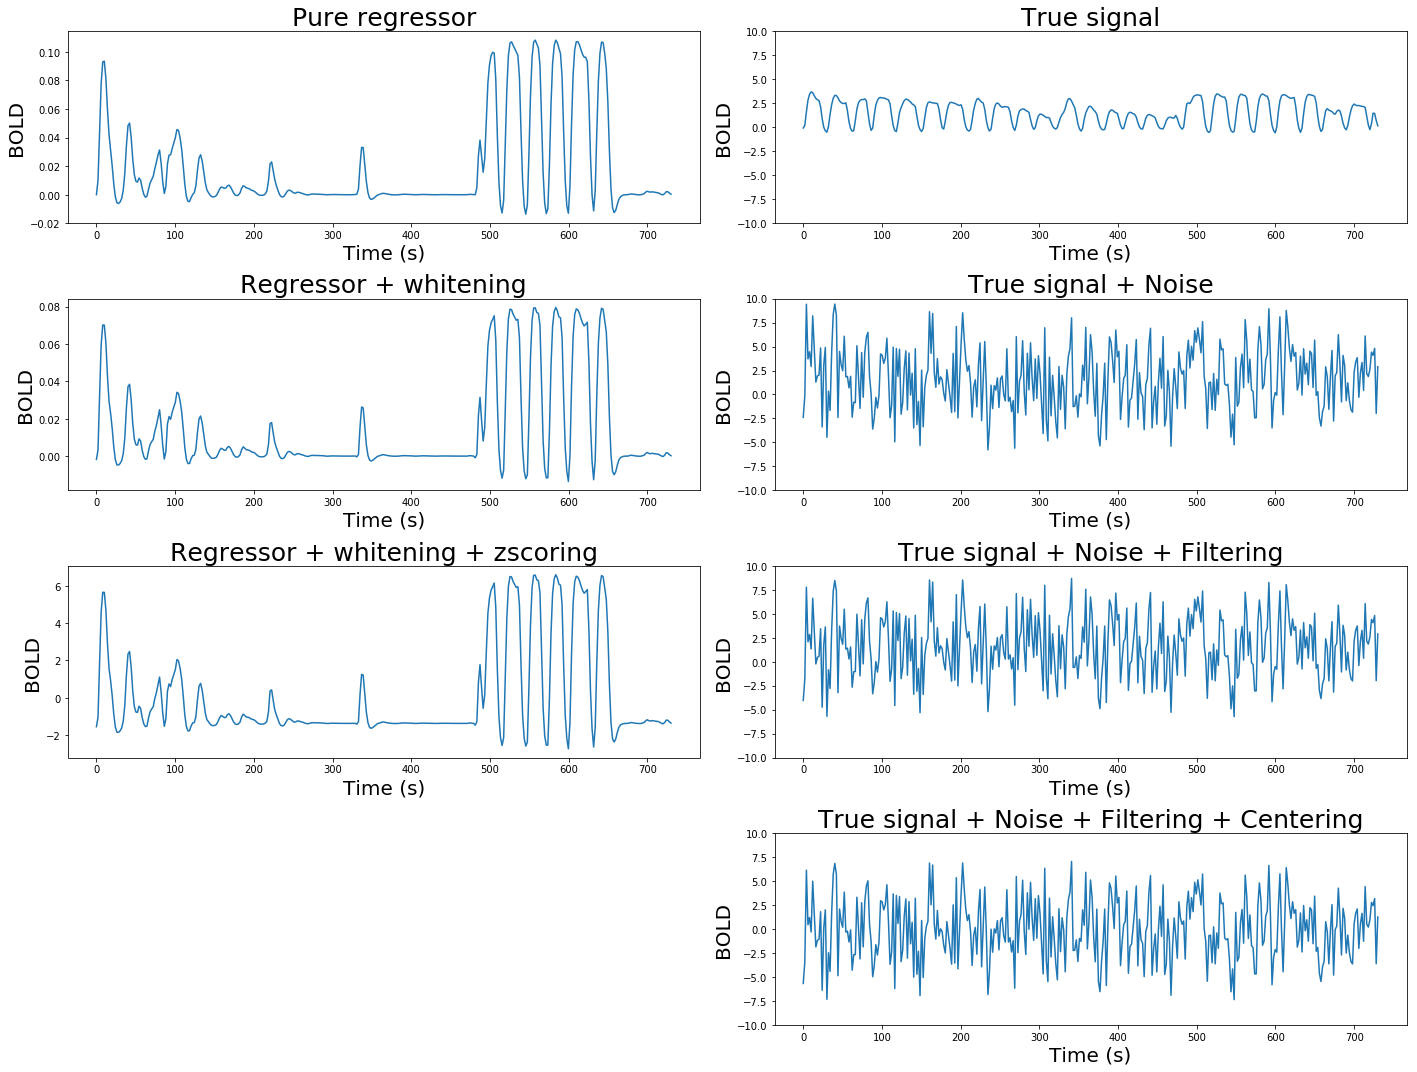

In [41]:
# PICK HERE WHICH REGRESSOR AND RESPONSE TO VISUALIZE
####################################################
k_scheme = 1
k_fit_N = 3
k_true_N = 3
k_fraction = 9
k_subject = 1
k_session = 2
i = 1   # Index of the regressor to visualize
####################################################

fontsize=20
title_fontsize = 25

y1_plot = copy.deepcopy(y_without_noise[k_scheme][k_true_N][k_fraction][k_subject][k_session])
y2_plot = copy.deepcopy(y_with_noise[k_scheme][k_true_N][k_fraction][k_subject][k_session])
y3_plot = copy.deepcopy(y_after_filtering[k_scheme][k_true_N][k_fraction][k_subject][k_session])
y4_plot = copy.deepcopy(yz[k_scheme][k_true_N][k_fraction][k_subject][k_session])

x1_plot = copy.deepcopy(X_before_whitening[k_scheme][k_fit_N][k_subject][k_session][:, i])
x2_plot = copy.deepcopy(X_after_whitening[k_scheme][k_fit_N][k_subject][k_session][:, i])
x3_plot = copy.deepcopy(Xz[k_scheme][k_fit_N][k_subject][k_session][:, i])

fig = plt.figure(figsize=(20, 15))

ax_up = fig.add_subplot(421)
between_scans_time = 2.0
ax_up.set_xlabel('Time (s)',fontsize=fontsize)
ax_up.set_ylabel('BOLD',fontsize=fontsize)
ax_up.set_title('Pure regressor', fontsize=title_fontsize)
ax_up.plot(np.linspace(0, between_scans_time*len(x1_plot), len(x1_plot)), x1_plot)

ax_down = fig.add_subplot(423)
ax_down.set_xlabel('Time (s)',fontsize=fontsize)
ax_down.set_ylabel('BOLD',fontsize=fontsize)
ax_down.set_title('Regressor + whitening', fontsize=title_fontsize)
ax_down.plot(np.linspace(0, between_scans_time*len(x2_plot), len(x2_plot)), x2_plot)

ax_down = fig.add_subplot(425)
ax_down.set_xlabel('Time (s)',fontsize=fontsize)
ax_down.set_ylabel('BOLD',fontsize=fontsize)
ax_down.set_title('Regressor + whitening + zscoring', fontsize=title_fontsize)
ax_down.plot(np.linspace(0, between_scans_time*len(x3_plot), len(x3_plot)), x3_plot)

ax1 = fig.add_subplot(422)
ax1.plot(np.linspace(0, between_scans_time*len(y1_plot), len(y1_plot)), y1_plot)
ax1.set_xlabel('Time (s)',fontsize=fontsize)
ax1.set_ylabel('BOLD',fontsize=fontsize)
ax1.set_title('True signal', fontsize=title_fontsize)
ax1.set_ylim([-10, 10])

ax2 = fig.add_subplot(424)
ax2.plot(np.linspace(0, between_scans_time*len(y2_plot), len(y2_plot)), y2_plot)
ax2.set_xlabel('Time (s)',fontsize=fontsize)
ax2.set_ylabel('BOLD',fontsize=fontsize)
ax2.set_title('True signal + Noise', fontsize=title_fontsize)
ax2.set_ylim([-10, 10])

ax3 = fig.add_subplot(426)
ax3.plot(np.linspace(0, between_scans_time*len(y3_plot), len(y3_plot)), y3_plot)
ax3.set_xlabel('Time (s)',fontsize=fontsize)
ax3.set_ylabel('BOLD',fontsize=fontsize)
ax3.set_title('True signal + Noise + Filtering', fontsize=title_fontsize)
ax3.set_ylim([-10, 10])

ax4 = fig.add_subplot(428)
ax4.plot(np.linspace(0, between_scans_time*len(y4_plot), len(y4_plot)), y4_plot)
ax4.set_xlabel('Time (s)',fontsize=fontsize)
ax4.set_ylabel('BOLD',fontsize=fontsize)
ax4.set_title('True signal + Noise + Filtering + Centering', fontsize=title_fontsize)
ax4.set_ylim([-10, 10])

fig.tight_layout()
plt.show()
#fig.savefig("figures_tmp/fmri_processes.pdf", bbox_inches='tight')


## Regression

### Visualization of an example of training and testing

Here we select arbitrary values of hyperparameters and plot the result for one fit.


Scheme : gaussian_ppc
true_N = 5
fit_N = 8
Subject n°1
Left-out session : 2
r2_true_test = 0.5404272956863503
r2_raw_test = 0.07688846887899359
rho_true_test = 0.8167337176714295
rho_raw_test = 0.27728770055484536


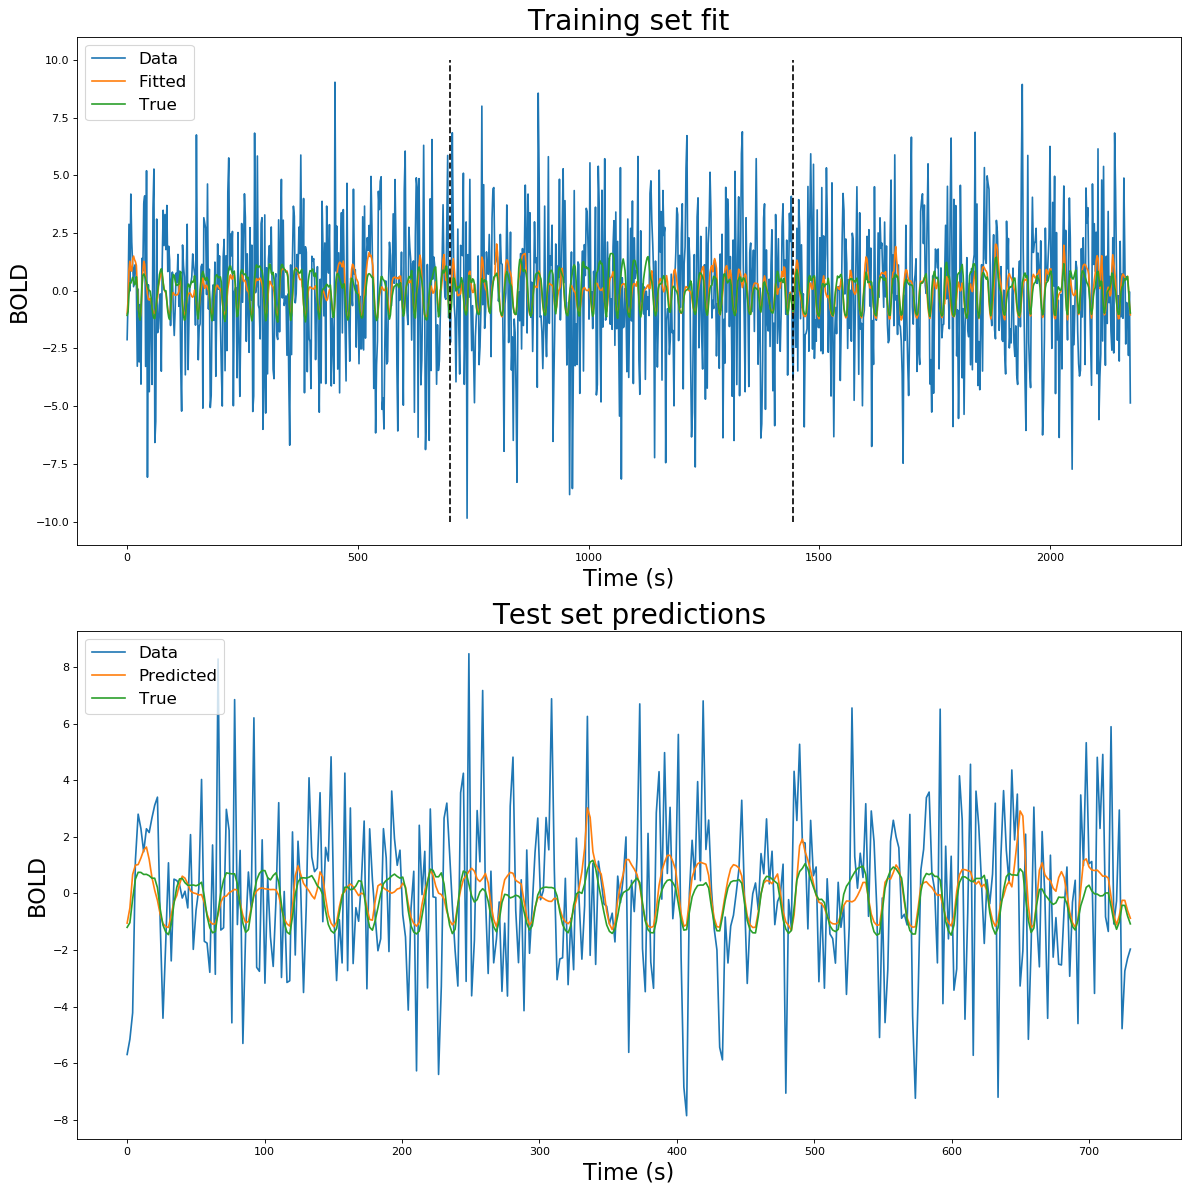

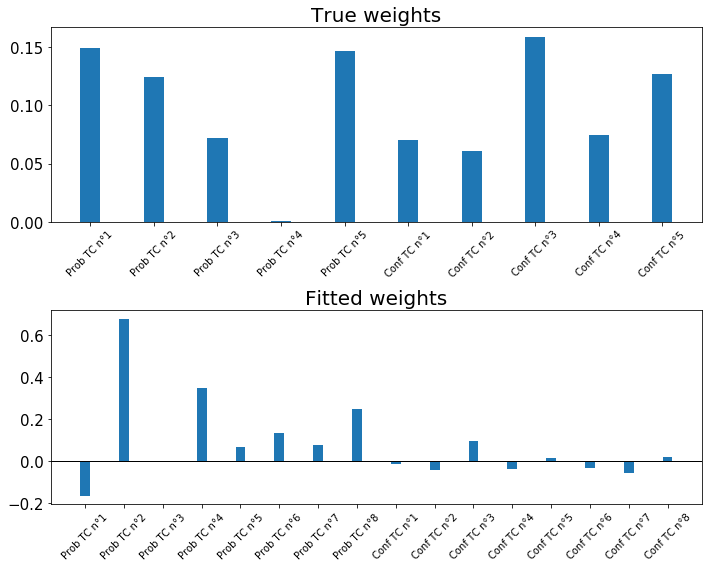

[0.07016747 0.06113714 0.1588679  0.07476015 0.12639579 0.14897523
 0.12382571 0.07200113 0.00031843 0.14620795]
[-0.0146356  -0.04179566  0.09310897 -0.03818453  0.01300359 -0.03419795
 -0.05629107  0.01706707 -0.1656029   0.67950359 -0.00580622  0.34881298
  0.06883822  0.13494551  0.07774755  0.2501136 ]
SNR_eff = 0.06834938469706245


In [42]:
# PICK HERE WHICH MODEL, SET, ETC. TO VISUALIZE
#######################################
k_scheme =0
k_fit_N =6
k_true_N = 3
k_fraction = 0
k_subject = 1
k_session = 2
#######################################

# k_population = 4
# k_sparsity = 3

# k_fraction = 5*k_sparsity - 4*k_population % 20


true_N = N_array[k_true_N]
fit_N = N_array[k_fit_N]

print('Scheme : '+scheme_array[k_scheme]+'\n'+'true_N = '+str(true_N)+'\nfit_N = '+str(fit_N)
      +'\n'+'Subject n°'+str(k_subject)+'\nLeft-out session : '+str(k_session))

# Current cross-validation matrice and response
X_cv = copy.deepcopy(Xz[k_scheme][k_fit_N][k_subject])
y_cv = copy.deepcopy(yz[k_scheme][k_true_N][k_fraction][k_subject])
y_without_noise_cv = copy.deepcopy(yz_without_noise[k_scheme][k_true_N][k_fraction][k_subject])

X_train = copy.deepcopy(np.concatenate(X_cv[:k_session]+X_cv[k_session+1:], axis=0))
y_train = copy.deepcopy(np.concatenate(y_cv[:k_session]+y_cv[k_session+1:], axis=0))
y_without_noise_train = copy.deepcopy(np.concatenate(y_without_noise_cv[:k_session]+y_without_noise_cv[k_session+1:], axis=0))

X_test = copy.deepcopy(X_cv[k_session])
y_test = copy.deepcopy(y_cv[k_session])
y_without_noise_test = copy.deepcopy(y_without_noise_cv[k_session])


# Train the model using the training set
regr.fit(X_train, y_train)
y_hat_train = regr.predict(X_train)

# Make predictions using the testing set
y_pred = np.transpose(np.array([regr.predict(X_test)]))

# Second fit
regr2.fit(y_pred, y_test)
y_pred2 = regr2.predict(y_pred)

# Train and test results
r2_raw_test_unique = r2_score(y_test, y_pred2)
r2_raw_train_unique = r2_score(y_train, y_hat_train)
rho_raw_train_unique = pearsonr(y_train, y_hat_train)[0]
rho_raw_test_unique = pearsonr(y_test, y_pred2)[0]

r2_true_test_unique = r2_score(y_without_noise_test, y_pred2)
r2_true_train_unique = r2_score(y_without_noise_train, y_hat_train)
rho_true_train_unique = pearsonr(y_without_noise_train, y_hat_train)[0]
rho_true_test_unique = pearsonr(y_without_noise_test, y_pred2)[0]

# Plot the signal and the response
fontsize=20
title_fontsize=25

fig1 = plt.figure(figsize=(15,15), dpi= 80)
ax_y_train = fig1.add_subplot(211)
ax_y_train.plot(np.linspace(0, between_scans_time*len(y_train), len(y_train)), y_train, label='Data')
ax_y_train.plot(np.linspace(0, between_scans_time*len(y_hat_train), len(y_hat_train)), y_hat_train, label='Fitted')
ax_y_train.plot(np.linspace(0, between_scans_time*len(y_without_noise_train), len(y_without_noise_train)), y_without_noise_train, label='True')
ax_y_train.legend(loc=2, prop={'size': 15})
ax_y_train.set_xlabel('Time (s)', fontsize=fontsize)
ax_y_train.set_ylabel('BOLD', fontsize=fontsize)
ax_y_train.set_title('Training set fit', fontsize=title_fontsize)
# Separate sessions
#print(str(y_cv[0]))
dash_line = [None for k in range(n_sessions-2)]
dash_position = 0
for k in range(n_sessions-2):
    dash_position += between_scans_time*len(y_cv[k])
    dash_line[k] = ax_y_train.plot(dash_position*np.ones(10), np.linspace(-10, 10, 10), color='black', linestyle='--')

ax_y_test = fig1.add_subplot(212)
ax_y_test.plot(np.linspace(0, between_scans_time*len(y_test), len(y_test)), y_test, label='Data')
ax_y_test.plot(np.linspace(0, between_scans_time*len(y_pred), len(y_pred)), y_pred2, label='Predicted')
ax_y_test.plot(np.linspace(0, between_scans_time*len(y_without_noise_test), len(y_without_noise_test)), y_without_noise_test, label='True')
ax_y_test.legend(loc=2, prop={'size': 15})
ax_y_test.set_xlabel('Time (s)', fontsize=fontsize)
ax_y_test.set_ylabel('BOLD', fontsize=fontsize)
ax_y_test.set_title('Test set predictions', fontsize=title_fontsize)
fig1.tight_layout()

print('r2_true_test = '+str(r2_true_test_unique))
print('r2_raw_test = '+str(r2_raw_test_unique))
print('rho_true_test = '+str(rho_true_test_unique))
print('rho_raw_test = '+str(rho_raw_test_unique))

## Plot the weights

true_weights = weights[k_scheme][k_true_N][k_fraction][k_subject]
fit_weights = regr.coef_


#print(np.matmul(X_test, fit_weights))

# Plot the true weights
width = 1/np.sqrt((2*true_N))

fig2 = plt.figure(figsize=(10,8))
ax_true_weights = fig2.add_subplot(211)
labels = [None for k in range(2*true_N)]
for k in range(2*true_N):
    if k<true_N:
        labels[k] = 'Prob TC n°'+str(k%true_N+1)
    else:
        labels[k] = 'Conf TC n°'+str(k%true_N+1)
ax_true_weights.bar(labels, true_weights, width=width)
ax_true_weights.tick_params(labelsize=15)
ax_true_weights.set_title('True weights', fontsize=20)
#ax_true_weights.set_ylim([-1, 1])
ax_true_weights.set_xticklabels(labels, rotation=45, fontsize=10)
ax_true_weights.axhline(0, color="black", linewidth=1)

width = 1/np.sqrt((2*fit_N))
ax_fit_weights = fig2.add_subplot(212)
labels = [None for k in range(2*fit_N)]
for k in range(2*fit_N):
    if k<fit_N:
        labels[k] = 'Prob TC n°'+str(k%fit_N+1)
    else:
        labels[k] = 'Conf TC n°'+str(k%fit_N+1)
ax_fit_weights.bar(labels, fit_weights, width=width)
ax_fit_weights.tick_params(labelsize=15)
ax_fit_weights.set_title('Fitted weights', fontsize=20)
# ax_fit_weights.set_ylim([-1, 1])
ax_fit_weights.set_xticklabels(labels, rotation=45, fontsize=10)
ax_fit_weights.axhline(0, color="black", linewidth=1)
fig2.tight_layout()
plt.show()    

print(true_weights)
print(fit_weights)


snr_eff = np.var(y_without_noise_test)/(np.var(y_without_noise_test)+np.var(y_test-y_without_noise_test))
print('SNR_eff = '+str(snr_eff))
fig1.savefig("figures_tmp/fit_example_N_fit"+str(fit_N)+"_N_true"+str(true_N)+"_snr"+str(snr)+".pdf", bbox_inches='tight')
fig2.savefig("figures_tmp/weights_fit_example_N_fit"+str(fit_N)+"_N_true"+str(true_N)+"_snr"+str(snr)+".pdf", bbox_inches='tight')


### Cross-validation loops (simulation 1)

In [46]:
# The loops
# The quantity to be computed during the cross validation
r2_test = np.zeros((n_schemes, n_N, n_N, n_fractions, n_subjects, n_sessions))
r2_train = np.zeros((n_schemes, n_N, n_N, n_fractions, n_subjects, n_sessions))
rho_test = np.zeros((n_schemes, n_N, n_N, n_fractions, n_subjects, n_sessions))
rho_train = np.zeros((n_schemes, n_N, n_N, n_fractions, n_subjects, n_sessions))

r2_true_test = np.zeros((n_schemes, n_N, n_N, n_fractions, n_subjects, n_sessions))
r2_true_train = np.zeros((n_schemes, n_N, n_N, n_fractions, n_subjects, n_sessions))
rho_true_test = np.zeros((n_schemes, n_N, n_N, n_fractions, n_subjects, n_sessions))
rho_true_train = np.zeros((n_schemes, n_N, n_N, n_fractions, n_subjects, n_sessions))

### BEGINNING OF LOOPS OVER HYPERPARAMETERS
for k_scheme, k_fit_N in itertools.product(range(n_schemes), range(n_N)):
    for k_true_N, k_fraction, k_subject in itertools.product(range(n_N), range(n_fractions), range(n_subjects)):
        # Current cross-validation matrix and response
        X_cv = copy.deepcopy(Xz[k_scheme][k_fit_N][k_subject])
        y_cv = copy.deepcopy(yz[k_scheme][k_true_N][k_fraction][k_subject])
        y_without_noise_cv = copy.deepcopy(yz_without_noise[k_scheme][k_true_N][k_fraction][k_subject])

        # LOOP OVER SESSIONS (CV)
        for k_session in range(n_sessions):
            X_train = copy.deepcopy(np.concatenate(X_cv[:k_session]+X_cv[k_session+1:], axis=0))
            y_train = copy.deepcopy(np.concatenate(y_cv[:k_session]+y_cv[k_session+1:], axis=0))
            X_test = copy.deepcopy(X_cv[k_session])
            y_test = copy.deepcopy(y_cv[k_session])

            y_without_noise_train = copy.deepcopy(np.concatenate(y_without_noise_cv[:k_session]+y_without_noise_cv[k_session+1:], axis=0))
            y_without_noise_test = copy.deepcopy(y_without_noise_cv[k_session])

            # Train the model using the training set
            regr.fit(X_train, y_train)
            y_hat_train = regr.predict(X_train)
            # Make predictions using the testing set
            y_pred = regr.predict(X_test)
            y_pred_tmp = np.transpose(np.array([y_pred]))

            # Second fit
            regr2.fit(y_pred_tmp, y_test)
            y_pred2 = regr2.predict(y_pred_tmp)

            # Train and test results
            r2_test_unique = r2_score(y_without_noise_test, y_pred2)
            r2_train_unique = r2_score(y_train, y_hat_train)
            rho_train_unique = pearsonr(y_train, y_hat_train)[0]
            rho_test_unique = pearsonr(y_without_noise_test, y_pred2)[0]

            r2_train[k_scheme, k_fit_N, k_true_N, k_fraction, k_subject, k_session] \
                = r2_score(y_train, y_hat_train)
            r2_test[k_scheme, k_fit_N, k_true_N, k_fraction, k_subject, k_session] \
                = r2_score(y_test, y_pred2)


            rho_train[k_scheme, k_fit_N, k_true_N, k_fraction, k_subject, k_session] \
                = pearsonr(y_train, y_hat_train)[0]
            rho_test[k_scheme, k_fit_N, k_true_N, k_fraction, k_subject, k_session] \
                = pearsonr(y_test, y_pred2)[0]
            rho_true_train[k_scheme, k_fit_N, k_true_N, k_fraction, k_subject, k_session] \
                = pearsonr(y_without_noise_train, y_hat_train)[0]
            rho_true_test[k_scheme, k_fit_N, k_true_N, k_fraction, k_subject, k_session] \
                = pearsonr(y_without_noise_test, y_pred2)[0]

            r2_true_train[k_scheme, k_fit_N, k_true_N, k_fraction, k_subject, k_session] \
                = r2_score(y_without_noise_train, y_hat_train)

            r2_true_test[k_scheme, k_fit_N, k_true_N, k_fraction, k_subject, k_session] \
                = r2_score(y_without_noise_test, y_pred2)

    print('Scheme n'+str(k_scheme)+' with N_fit='+str(N_array[k_fit_N])+' done.')
        
# If MSE       
#         r2_train[k_scheme, k_fit_N, k_true_N, k_fraction, k_subject, k_session] \
#             = mean_squared_error(y_train, y_hat_train)
#         r2_test[k_scheme, k_fit_N, k_true_N, k_fraction, k_subject, k_session] \
#             = mean_squared_error(y_test, y_pred2)

#         r2_true_train[k_scheme, k_fit_N, k_true_N, k_fraction, k_subject, k_session] \
#             = mean_squared_error(y_without_noise_train, y_hat_train)
            
#         r2_true_test[k_scheme, k_fit_N, k_true_N, k_fraction, k_subject, k_session] \
#             = mean_squared_error(y_without_noise_test, y_pred2)


Scheme n0 with N_fit=2 done.
Scheme n0 with N_fit=3 done.
Scheme n0 with N_fit=4 done.
Scheme n0 with N_fit=5 done.
Scheme n0 with N_fit=6 done.
Scheme n0 with N_fit=7 done.
Scheme n0 with N_fit=8 done.
Scheme n0 with N_fit=10 done.
Scheme n0 with N_fit=14 done.
Scheme n0 with N_fit=20 done.
Scheme n1 with N_fit=2 done.
Scheme n1 with N_fit=3 done.
Scheme n1 with N_fit=4 done.
Scheme n1 with N_fit=5 done.
Scheme n1 with N_fit=6 done.
Scheme n1 with N_fit=7 done.
Scheme n1 with N_fit=8 done.
Scheme n1 with N_fit=10 done.
Scheme n1 with N_fit=14 done.
Scheme n1 with N_fit=20 done.
Scheme n2 with N_fit=2 done.
Scheme n2 with N_fit=3 done.
Scheme n2 with N_fit=4 done.
Scheme n2 with N_fit=5 done.
Scheme n2 with N_fit=6 done.
Scheme n2 with N_fit=7 done.
Scheme n2 with N_fit=8 done.
Scheme n2 with N_fit=10 done.
Scheme n2 with N_fit=14 done.
Scheme n2 with N_fit=20 done.
Scheme n3 with N_fit=2 done.
Scheme n3 with N_fit=3 done.
Scheme n3 with N_fit=4 done.
Scheme n3 with N_fit=5 done.
Schem

In [ ]:
#np.save('output/results/r2_test_snr'+str(snr)+'.npy', r2_test)
#np.save('output/results/r2_train_snr'+str(snr)+'.npy', r2_train)
#np.save('output/results/rho_test_snr'+str(snr)+'.npy', rho_test)
#np.save('output/results/rho_train_snr'+str(snr)+'.npy', rho_train)
#np.save('output/results/r2_true_test_snr'+str(snr)+'.npy', r2_true_test)
#np.save('output/results/r2_true_train_snr'+str(snr)+'.npy', r2_true_train)
#np.save('output/results/rho_true_test_snr'+str(snr)+'.npy', rho_true_test)
#np.save('output/results/rho_true_train_snr'+str(snr)+'.npy', rho_true_train)

## Handle the data

### Row data loading and visualization


In [ ]:
# Some reloading (one should run it if the loops have already been performed and results saved)
if distrib_type=='transition':
    r2_test = np.load('output/results/snr'+str(snr)+'/transition/all/r2_test_snr'+str(snr)+'.npy')
    r2_true_test = np.load('output/results/snr'+str(snr)+'/transition/all/r2_true_test_snr'+str(snr)+'.npy')
    r2_train = np.load('output/results/snr'+str(snr)+'/transition/all/r2_train_snr'+str(snr)+'.npy')
    rho_test = np.load('output/results/snr'+str(snr)+'/transition/all/rho_test_snr'+str(snr)+'.npy')
    rho_train = np.load('output/results/snr'+str(snr)+'/transition/all/rho_train_snr'+str(snr)+'.npy')
    r2_true_train = np.load('output/results/snr'+str(snr)+'/transition/all/r2_true_train_snr'+str(snr)+'.npy')
    rho_true_test = np.load('output/results/snr'+str(snr)+'/transition/all/rho_true_test_snr'+str(snr)+'.npy')
    rho_true_train = np.load('output/results/snr'+str(snr)+'/transition/all/rho_true_train_snr'+str(snr)+'.npy')

elif distrib_type=='bernoulli':
    r2_test = np.load('output/results/snr'+str(snr)+'/bernoulli/all/r2_test_snr'+str(snr)+'.npy')
    r2_true_test = np.load('output/results/snr'+str(snr)+'/bernoulli/all/r2_true_test_snr'+str(snr)+'.npy')
    r2_train = np.load('output/results/snr'+str(snr)+'/bernoulli/all/r2_train_snr'+str(snr)+'.npy')
    rho_test = np.load('output/results/snr'+str(snr)+'/bernoulli/all/rho_test_snr'+str(snr)+'.npy')
    rho_train = np.load('output/results/snr'+str(snr)+'/bernoulli/all/rho_train_snr'+str(snr)+'.npy')
    r2_true_train = np.load('output/results/snr'+str(snr)+'/bernoulli/all/r2_true_train_snr'+str(snr)+'.npy')
    rho_true_test = np.load('output/results/snr'+str(snr)+'/bernoulli/all/rho_true_test_snr'+str(snr)+'.npy')
    rho_true_train = np.load('output/results/snr'+str(snr)+'/bernoulli/all/rho_true_train_snr'+str(snr)+'.npy')


In [49]:
#n_subjects = 1000

r2_raw_train_summary = np.zeros((n_schemes, n_N, n_N, n_fractions*n_subjects*n_sessions))
r2_raw_test_summary = np.zeros((n_schemes, n_N, n_N, n_fractions*n_subjects*n_sessions))
rho_raw_train_summary = np.zeros((n_schemes, n_N, n_N, n_fractions*n_subjects*n_sessions))
rho_raw_test_summary = np.zeros((n_schemes, n_N, n_N, n_fractions*n_subjects*n_sessions))
r2_true_train_summary = np.zeros((n_schemes, n_N, n_N, n_fractions*n_subjects*n_sessions))
r2_true_test_summary = np.zeros((n_schemes, n_N, n_N, n_fractions*n_subjects*n_sessions))
rho_true_train_summary = np.zeros((n_schemes, n_N, n_N, n_fractions*n_subjects*n_sessions))
rho_true_test_summary = np.zeros((n_schemes, n_N, n_N, n_fractions*n_subjects*n_sessions))

for k_scheme, k_fit_N, k_true_N in itertools.product(range(n_schemes), range(n_N), range(n_N)):
    
    r2_raw_test_summary[k_scheme, k_fit_N, k_true_N, :] = r2_test[k_scheme, k_fit_N, k_true_N, :, :, :].flatten()
    r2_true_test_summary[k_scheme, k_fit_N, k_true_N, :] = r2_true_test[k_scheme, k_fit_N, k_true_N, :, :, :].flatten()
    r2_raw_train_summary[k_scheme, k_fit_N, k_true_N, :] = r2_train[k_scheme, k_fit_N, k_true_N, :, :, :].flatten()
    rho_raw_train_summary[k_scheme, k_fit_N, k_true_N, :] = rho_train[k_scheme, k_fit_N, k_true_N, :, :, :].flatten()
    rho_raw_test_summary[k_scheme, k_fit_N, k_true_N, :] = rho_test[k_scheme, k_fit_N, k_true_N, :, :, :].flatten()
    r2_true_train_summary[k_scheme, k_fit_N, k_true_N, :] = r2_true_train[k_scheme, k_fit_N, k_true_N, :, :, :].flatten()
    rho_true_train_summary[k_scheme, k_fit_N, k_true_N, :] = rho_true_train[k_scheme, k_fit_N, k_true_N, :, :, :].flatten()
    rho_true_test_summary[k_scheme, k_fit_N, k_true_N, :] = rho_true_test[k_scheme, k_fit_N, k_true_N, :, :, :].flatten()

### Visualize results from simulation 1 (one example)

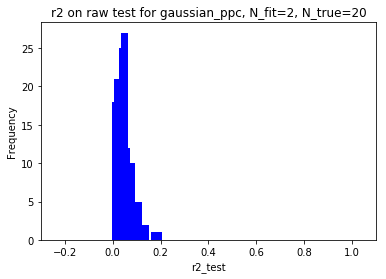

r2 var: 0.0009925546070510608
r2 mean: 0.042604014609380826


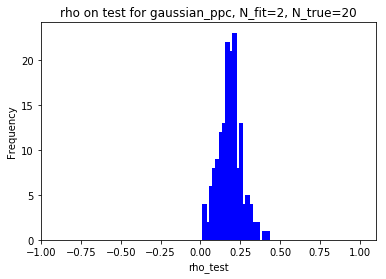

rho var: 0.005656390587737124
rho mean: 0.1922176475291582


In [50]:
# Visualize one specific histogram over r2 or rho

#########################################
k_scheme = 0
k_fit_N = 0
k_true_N = -1
##########################################

scheme = scheme_array[k_scheme]
fit_N = N_array[k_fit_N]
true_N = N_array[k_true_N]

#r2
metric_name = 'r2'
true_or_raw = 'raw'
train_or_test = 'test'
exec("metric = %s_%s_%s_summary[k_scheme, k_fit_N, k_true_N]" % (metric_name, true_or_raw, train_or_test))

nbins = 20
width = 0.03
fig = plt.figure()
ax = fig.add_subplot(111) 
ax.hist(metric, bins=nbins, align='left', color='b', width=width)
#ax.bar(negative_center, n_negative_values, color='r', width=2*width, align='center')
ax.set_title(metric_name+' on '+true_or_raw+' '+train_or_test+' for '+scheme+', N_fit='+str(fit_N)+', N_true='+str(true_N))
ax.set_xlabel('{}_{}'.format(metric_name, train_or_test))
ax.set_ylabel("Frequency")
ax.set_xlim([-0.3, 1.1])
plt.show()

print('r2 var: '+str(np.var(metric)))
print('r2 mean: '+str(np.mean(metric)))

# rho
metric_name = 'rho'
true_or_raw = 'raw'
train_or_test = 'test'
exec("metric = %s_%s_%s_summary[k_scheme, k_fit_N, k_true_N]" % (metric_name, true_or_raw, train_or_test))

nbins = 20
width = 0.03
fig = plt.figure()
ax = fig.add_subplot(111) 
ax.hist(metric, bins=nbins, align='left', color='b', width=width)
ax.set_title(metric_name+' on '+train_or_test+' for '+scheme+', N_fit='+str(fit_N)+', N_true='+str(true_N))
ax.set_xlabel('{}_{}'.format(metric_name, train_or_test))
ax.set_ylabel("Frequency")
ax.set_xlim([-1, 1.1])
plt.show()

print('rho var: '+str(np.var(metric)))
print('rho mean: '+str(np.mean(metric)))

## Plot confusion matrices for simulation 1

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
r2 on raw test set, gaussian_ppc


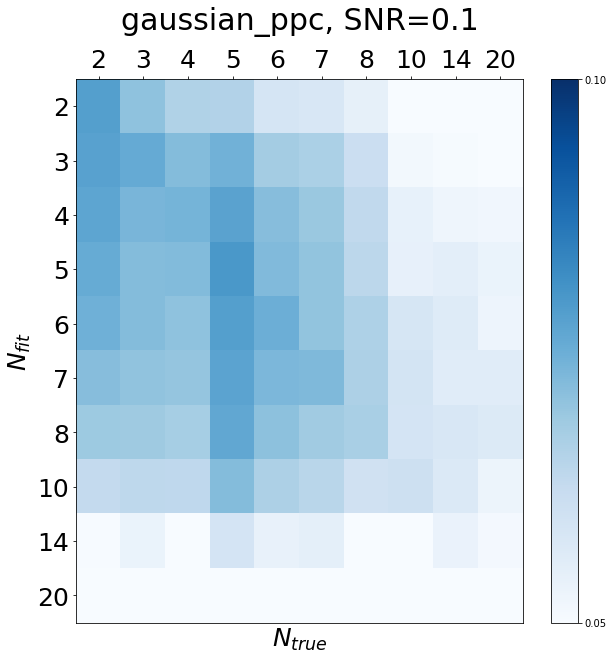

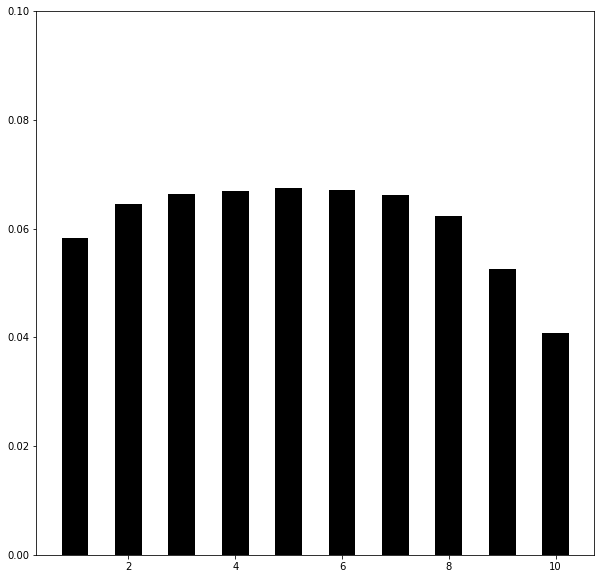

In [53]:
################################
k_scheme =0

################################
n_fractions = 20
scheme = scheme_array[k_scheme]

is_N_even = False

if is_N_even:
    selected_k_N = [0, 2, 4, 6, 7, 8, 9]
else:
    selected_k_N = [item for item in range(len(N_array))]

metric_name = 'r2'
true_or_raw = 'raw'
train_or_test = 'test'
print(selected_k_N)
#exec("metric = %s_%s_%s_summary[k_scheme, k_fit_N, k_true_N]" % (metric_name, true_or_raw, train_or_test))

print(metric_name+' on '+true_or_raw+' '+train_or_test+' set, '+scheme)

# Visualize the entire confusion matrix
nbins = 20
width = 0.04

#fig, ax = plt.subplots(n_N, n_N, sharex='col', sharey='row', figsize = (10, 10))
#for k_fit_N in range(n_N):
#    for k_true_N in range(n_N):
#        exec("metric = %s_%s_%s_summary[k_scheme, k_fit_N, k_true_N]" % (metric_name, true_or_raw, train_or_test))
#        fit_N = N_array[k_fit_N]
#        true_N = N_array[k_true_N]
#        # We set the negative r2 to the same value
#        negative_center = -0.2
#        n_negative_values = 0
#        if metric_name.find('r2')!=-1:
#            for k, metric_value in enumerate(metric):
#                if metric_value <0:
#                    metric[k] = negative_center
#                    n_negative_values += 1
#
#        ax[k_fit_N, k_true_N].hist(metric, bins=nbins, align='left', color='b', width=width)
#        ax[k_fit_N, k_true_N].bar(negative_center, n_negative_values, color='r', width=2*width, align='center')
#        ax[k_fit_N, k_true_N].set_title('N_fit='+str(fit_N)+', N_true='+str(true_N))
#        ax[k_fit_N, k_true_N].set_xlabel('{}_{}'.format(metric_name, train_or_test))
#        ax[k_fit_N, k_true_N].set_ylabel("Frequency")
#        if metric_name.find('r2')!=-1:
#            ax[k_fit_N, k_true_N].set_xlim([-0.3, 1.1])
#        else:
#            ax[k_fit_N, k_true_N].set_xlim([-1, 1])
#        ax[k_fit_N, k_true_N].set_ylim([0, n_fractions*n_subjects*n_sessions/4])
#fig.tight_layout()
#plt.show()

# Plot the confusion matrix of the mean
column_labels = copy.deepcopy(N_array[selected_k_N])
row_labels = copy.deepcopy(N_array[selected_k_N])

fig, ax = plt.subplots(figsize=(10,10))
fontsize = 25
exec("metric = copy.deepcopy(%s_%s_%s_summary[k_scheme, :, :, :])" % (metric_name, true_or_raw, train_or_test))
# We set the negative r2 to the same value
data = np.mean(metric[selected_k_N, :, :], axis=2)
data = data[:, selected_k_N]
min_value = 0.05
max_value = 0.1

heatmap = ax.pcolor(data, cmap=plt.cm.Blues, vmin=min_value, vmax=max_value)

# put the major ticks at the middle of each cell
ax.set_xticks(np.arange(data.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(data.shape[0]) + 0.5, minor=False)

# want a more natural, table-like display
ax.invert_yaxis()
ax.xaxis.tick_top()

ax.set_xticklabels(column_labels, minor=False, fontsize=fontsize)
ax.set_yticklabels(row_labels, minor=False, fontsize=fontsize)
ax.set_ylabel('$N_{fit}$', fontsize=fontsize)
ax.set_xlabel('$N_{true}$', fontsize=fontsize)
plt.title(scheme+', SNR='+str(snr), y=1.08, fontsize=fontsize+5)
cbar = fig.colorbar(heatmap, ticks=[min_value, max_value])
# Bar plots of the mean over the column
mean_r2 = np.mean(data,axis=1)
fig_bar, ax_bar = plt.subplots(figsize=(10, 10))
ax_bar.bar(np.linspace(1, len(mean_r2), len(mean_r2), endpoint=True), mean_r2, color='black', width=0.5, align='center')
ax_bar.set_ylim([0, 0.1])

plt.show()

#if is_N_even:
#    fig.savefig("figures_tmp/simu1_results_"+distrib_type+"_scheme-"+scheme+"_snr"+str(snr)+"_EVEN.pdf", bbox_inches='tight')
#    fig_bar.savefig("figures_tmp/simu1_means_"+distrib_type+"_scheme-"+scheme+"_snr"+str(snr)+"_EVEN.pdf", bbox_inches='tight')
#else:
#    fig.savefig("figures_tmp/simu1_results_"+distrib_type+"_scheme-"+scheme+"_snr"+str(snr)+"_ALL.pdf", bbox_inches='tight')
#    fig_bar.savefig("figures_tmp/simu1_means_"+distrib_type+"_scheme-"+scheme+"_snr"+str(snr)+"_ALL.pdf", bbox_inches='tight')


(4, 10, 10, 20, 2, 4)


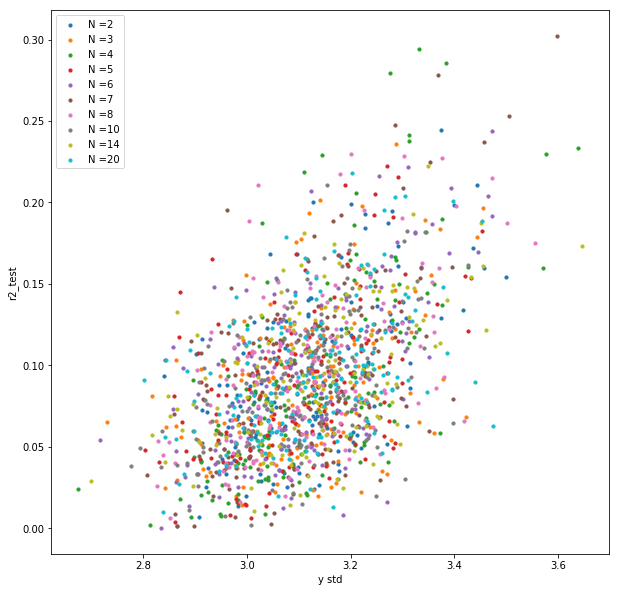

In [56]:
# DEBUG CELL! Scatter plots to visualize amplitude of y_sd compared to r2

sd_y_true = np.zeros((n_schemes, n_N, n_fractions, n_subjects, n_sessions))
sd_y = np.zeros((n_schemes, n_N, n_fractions, n_subjects, n_sessions))

for k_scheme, k_true_N, k_fraction, k_subject, k_session in itertools.product(range(n_schemes), 
                                                                            range(n_N), range(n_fractions), range(n_subjects), range(n_sessions)):
    sd_y_true[k_scheme, k_true_N, k_fraction, k_subject, k_session] = np.std(yz_without_noise[k_scheme][k_true_N][k_fraction][k_subject][k_session])

for k_scheme, k_true_N, k_fraction, k_subject, k_session in itertools.product(range(n_schemes), 
                                                                            range(n_N), range(n_fractions), range(n_subjects), range(n_sessions)):
    sd_y[k_scheme, k_true_N, k_fraction, k_subject, k_session] = np.std(yz[k_scheme][k_true_N][k_fraction][k_subject][k_session])


k_scheme = 1

print(r2_test.shape)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
for k_true_N in range(n_N):
    x = sd_y[k_scheme, k_true_N, :, :, :].flatten()
    y = r2_test[k_scheme, 4, k_true_N, :, :, :].flatten()
    ax.scatter(x, y, s=10, label='N ='+str(N_array[k_true_N]))
ax.set_xlabel('y std')
ax.set_ylabel('r2_test')
ax.legend()
plt.show()



### Find the optimal number of subjects to be generated

Plot the mean and variance of these distributions for different number of subjects

In [57]:
# Find the assymptotical value for n_fractions
n_subjects_array = np.linspace(1, n_subjects, num=int(n_subjects/5), endpoint=True).astype(int)

subject_r2_train_mean = np.zeros((n_schemes, n_N, n_N, len(n_subjects_array)))
subject_r2_train_var = np.zeros((n_schemes, n_N, n_N, len(n_subjects_array)))

subject_r2_test_mean = np.zeros((n_schemes, n_N, n_N, len(n_subjects_array)))
subject_r2_test_var = np.zeros((n_schemes, n_N, n_N, len(n_subjects_array)))

subject_r2_true_test_mean = np.zeros((n_schemes, n_N, n_N, len(n_subjects_array)))
subject_r2_true_test_var = np.zeros((n_schemes, n_N, n_N, len(n_subjects_array)))

subject_rho_train_mean = np.zeros((n_schemes, n_N, n_N, len(n_subjects_array)))
subject_rho_train_var = np.zeros((n_schemes, n_N, n_N, len(n_subjects_array)))

subject_rho_test_mean = np.zeros((n_schemes, n_N, n_N, len(n_subjects_array)))
subject_rho_test_var = np.zeros((n_schemes, n_N, n_N, len(n_subjects_array)))

for k_n_subjects, n_subjects in enumerate(n_subjects_array):
    for k_scheme, k_fit_N, k_true_N in itertools.product(range(n_schemes), range(n_N), range(n_N)):            
        subject_r2_train_mean[k_scheme, k_fit_N, k_true_N, k_n_subjects] = \
            np.mean(r2_train[k_scheme, k_fit_N, k_true_N, :, :n_subjects, :].flatten())
        subject_r2_train_var[k_scheme, k_fit_N, k_true_N, k_n_subjects] = \
            np.var(r2_train[k_scheme, k_fit_N, k_true_N, :, :n_subjects, :].flatten())
                                      
        subject_r2_test_mean[k_scheme, k_fit_N, k_true_N, k_n_subjects] = \
            np.mean(r2_test[k_scheme, k_fit_N, k_true_N, :, :n_subjects, :].flatten())
        subject_r2_test_var[k_scheme, k_fit_N, k_true_N, k_n_subjects] = \
            np.var(r2_test[k_scheme, k_fit_N, k_true_N, :, :n_subjects, :].flatten())
        
        subject_r2_true_test_mean[k_scheme, k_fit_N, k_true_N, k_n_subjects] = \
            np.mean(r2_true_test[k_scheme, k_fit_N, k_true_N, :, :n_subjects, :].flatten())
        subject_r2_true_test_var[k_scheme, k_fit_N, k_true_N, k_n_subjects] = \
            np.var(r2_true_test[k_scheme, k_fit_N, k_true_N, :, :n_subjects, :].flatten())

        subject_rho_train_mean[k_scheme, k_fit_N, k_true_N, k_n_subjects] = \
            np.mean(rho_train[k_scheme, k_fit_N, k_true_N, :, :n_subjects, :].flatten())
        subject_rho_train_var[k_scheme, k_fit_N, k_true_N, k_n_subjects] = \
            np.var(rho_train[k_scheme, k_fit_N, k_true_N, :, :n_subjects, :].flatten())

        subject_rho_test_mean[k_scheme, k_fit_N, k_true_N, k_n_subjects] = \
            np.mean(rho_test[k_scheme, k_fit_N, k_true_N, :, :n_subjects, :].flatten())
        subject_rho_test_var[k_scheme, k_fit_N, k_true_N, k_n_subjects] = \
            np.var(rho_test[k_scheme, k_fit_N, k_true_N, :, :n_subjects, :].flatten())

Scheme : sigmoid_ppc
true_N = 6
fit_N = 5



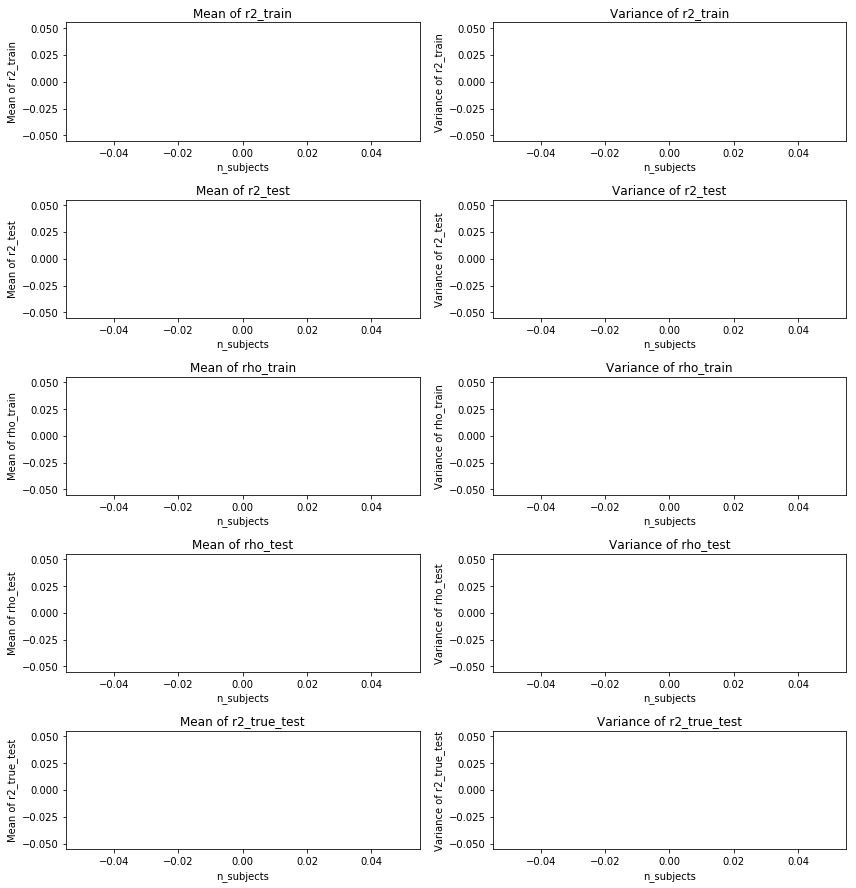

In [58]:
# Visualize the evolution of r2 according to the number of subjects
k_scheme = 1
k_fit_N = 3
k_true_N = 4

true_N = N_array[k_true_N]
fit_N = N_array[k_fit_N]

print('Scheme : '+scheme_array[k_scheme]+'\n'+'true_N = '+str(true_N)+'\nfit_N = '+str(fit_N)
      +'\n')

subject_r2_train_mean_to_plot = subject_r2_train_mean[k_scheme, k_fit_N, k_true_N, :]
subject_r2_train_var_to_plot = subject_r2_train_var[k_scheme, k_fit_N, k_true_N, :]

subject_r2_test_mean_to_plot = subject_r2_test_mean[k_scheme, k_fit_N, k_true_N, :]
subject_r2_test_var_to_plot = subject_r2_test_var[k_scheme, k_fit_N, k_true_N, :]

subject_rho_train_mean_to_plot = subject_rho_train_mean[k_scheme, k_fit_N, k_true_N, :]
subject_rho_train_var_to_plot = subject_rho_train_var[k_scheme, k_fit_N, k_true_N, :]

subject_rho_test_mean_to_plot = subject_rho_test_mean[k_scheme, k_fit_N, k_true_N, :]
subject_rho_test_var_to_plot = subject_rho_test_var[k_scheme, k_fit_N, k_true_N, :]

subject_r2_true_test_mean_to_plot = subject_r2_true_test_mean[k_scheme, k_fit_N, k_true_N, :]
subject_r2_true_test_var_to_plot = subject_r2_true_test_var[k_scheme, k_fit_N, k_true_N, :]

fig = plt.figure(figsize=(12, 12))
ax_r2_train_mean = fig.add_subplot(521)
ax_r2_train_mean.plot(n_subjects_array, subject_r2_train_mean_to_plot)
ax_r2_train_mean.set_xlabel('n_subjects')
ax_r2_train_mean.set_ylabel('Mean of r2_train')
ax_r2_train_mean.set_title('Mean of r2_train')

ax_r2_train_var = fig.add_subplot(522)
ax_r2_train_var.plot(n_subjects_array, subject_r2_train_var_to_plot)
ax_r2_train_var.set_xlabel('n_subjects')
ax_r2_train_var.set_ylabel('Variance of r2_train')
ax_r2_train_var.set_title('Variance of r2_train')

ax_r2_test_mean = fig.add_subplot(523)
ax_r2_test_mean.plot(n_subjects_array, subject_r2_test_mean_to_plot)
ax_r2_test_mean.set_xlabel('n_subjects')
ax_r2_test_mean.set_ylabel('Mean of r2_test')
ax_r2_test_mean.set_title('Mean of r2_test')

ax_r2_test_var = fig.add_subplot(524)
ax_r2_test_var.plot(n_subjects_array, subject_r2_test_var_to_plot)
ax_r2_test_var.set_xlabel('n_subjects')
ax_r2_test_var.set_ylabel('Variance of r2_test')
ax_r2_test_var.set_title('Variance of r2_test')

ax_rho_train_mean = fig.add_subplot(525)
ax_rho_train_mean.plot(n_subjects_array, subject_rho_train_mean_to_plot)
ax_rho_train_mean.set_xlabel('n_subjects')
ax_rho_train_mean.set_ylabel('Mean of rho_train')
ax_rho_train_mean.set_title('Mean of rho_train')

ax_rho_train_var = fig.add_subplot(526)
ax_rho_train_var.plot(n_subjects_array, subject_rho_train_var_to_plot)
ax_rho_train_var.set_xlabel('n_subjects')
ax_rho_train_var.set_ylabel('Variance of rho_train')
ax_rho_train_var.set_title('Variance of rho_train')

ax_rho_test_mean = fig.add_subplot(527)
ax_rho_test_mean.plot(n_subjects_array, subject_rho_test_mean_to_plot)
ax_rho_test_mean.set_xlabel('n_subjects')
ax_rho_test_mean.set_ylabel('Mean of rho_test')
ax_rho_test_mean.set_title('Mean of rho_test')

ax_rho_test_var = fig.add_subplot(528)
ax_rho_test_var.plot(n_subjects_array, subject_rho_test_var_to_plot)
ax_rho_test_var.set_xlabel('n_subjects')
ax_rho_test_var.set_ylabel('Variance of rho_test')
ax_rho_test_var.set_title('Variance of rho_test')
fig.tight_layout()

ax_r2_true_test_mean = fig.add_subplot(5,2, 9)
ax_r2_true_test_mean.plot(n_subjects_array, subject_r2_true_test_mean_to_plot)
ax_r2_true_test_mean.set_xlabel('n_subjects')
ax_r2_true_test_mean.set_ylabel('Mean of r2_true_test')
ax_r2_true_test_mean.set_title('Mean of r2_true_test')

ax_r2_true_test_var = fig.add_subplot(5,2,10)
ax_r2_true_test_var.plot(n_subjects_array, subject_r2_true_test_var_to_plot)
ax_r2_true_test_var.set_xlabel('n_subjects')
ax_r2_true_test_var.set_ylabel('Variance of r2_true_test')
ax_r2_true_test_var.set_title('Variance of r2_true_test')


plt.show()